In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import numpy as np

In [118]:
class data_visualisation:
    def __init__(self, df, instance):
        self.df=df
        self.instance=instance
        self.df=self.df[self.df['Instance']==self.instance]
        self.df.fillna(0)
        self.dummy_df()
        
                                
    def summarise_and_plot(self):

        # Define the parameters to plot
        parameters = ['Cp', 'Number childrens', 'Desired expansion policy', 'Desired simulation policy', 'Desired selection policy',"Ratio expansion"]

        # Calculate figure size based on the number of parameters
        num_params = len(parameters)
        fig_width = 6 * num_params  # 6 units width per parameter
        fig_height = 6  # Keep the height fixed for each row

        # Plotting Time to Find Solution vs parameters in the first row
        plt.figure(figsize=(fig_width, fig_height * 2))

        for i, param in enumerate(parameters):
            plt.subplot(2, num_params, i + 1)  # First row
            sns.violinplot(x=param, y='Time to find the solution', data=self.df, inner="quartile", split=True)
            plt.title(f'Time to Find Solution vs {param}')
            plt.xlabel(param)
            plt.ylabel('Time to Find Solution (seconds)')

        # Plotting Total Cost vs parameters in the second row
        for i, param in enumerate(parameters):
            plt.subplot(2, num_params, i + 1 + num_params)  # Second row
            sns.violinplot(x=param, y='Best node - cost', data=self.df, inner="quartile", split=True)
            plt.title(f'Total Cost vs {param}')
            plt.xlabel(param)
            plt.ylabel('Total Cost')

        plt.tight_layout()
        plt.show()
        
    def cp_vs_cost(self):
        
        palette = sns.color_palette("pastel", n_colors=len(self.df['Desired selection policy'].unique()))

        plt.figure(figsize=(14, 8))
        sns.boxplot(data=self.df,  # Ensure to use df_instance
                    x="Cp",
                    y="Best node - cost",
                    hue="Desired selection policy",
                    palette=palette)  # Apply the pastel palette

        plt.title(f"Cp vs Total Cost by Selection Policy - Instance {self.instance}")
        plt.xlabel("Cp Value")
        plt.ylabel("Total Cost")
        plt.tight_layout()
        plt.show()
        
    def cp_vs_time(self):
        
        palette = sns.color_palette("pastel", n_colors=len(self.df['Desired selection policy'].unique()))

        plt.figure(figsize=(14, 8))
        sns.boxplot(data=self.df,  # Ensure to use df_instance
                    x="Cp",
                    y="Time to find the solution",
                    hue="Desired selection policy",
                    palette=palette)  # Apply the pastel palette

        plt.title(f"Cp vs Time to find the solution by Selection Policy - Instance {self.instance}")
        plt.xlabel("Cp Value")
        plt.ylabel("Time to find the solution")
        plt.tight_layout()
        plt.show()
    
    def cp_vs_selection(self):
        
        palette = sns.color_palette("pastel", n_colors=len(self.df['Desired selection policy'].unique()))

        plt.figure(figsize=(14, 8))
        sns.boxplot(data=self.df,  # Ensure to use df_instance
                    x="Cp",
                    y="Number of SELECTION phases",
                    hue="Desired selection policy",
                    palette=palette)  # Apply the pastel palette

        plt.title(f"Cp vs Time to find the solution by Selection Policy - Instance {self.instance}")
        plt.xlabel("Cp Value")
        plt.ylabel("Time to find the solution")
        plt.tight_layout()
        plt.show()
        
    def cost_vs_ratio(self):
        
        palette = sns.color_palette("pastel", n_colors=len(self.df['Desired selection policy'].unique()))

        plt.figure(figsize=(14, 8))
        sns.boxplot(data=self.df,  # Ensure to use df_instance
                    x="Ratio expansion",
                    y="Best node - cost",
                    hue="Desired selection policy",
                    palette=palette)  # Apply the pastel palette

        plt.title(f"Ratio expansion vs Total cost by Selection Policy - Instance {self.instance}")
        plt.xlabel("Ratio expansion")
        plt.ylabel("Time to find the solution")
        plt.tight_layout()
        plt.show()
        
    def number_selection_vs_cp(self):

        palette = sns.color_palette("pastel", n_colors=len(self.df['Desired selection policy'].unique()))

        plt.figure(figsize=(16, 8))
        sns.violinplot(data=self.df,  # Ensure to use df_instance
                    x="Cp",
                    y="Number of SELECTION phases",
                    hue="Desired selection policy",
                    palette=palette)  # Apply the pastel palette

        plt.title(f"Cp vs Number of selection by Selection Policy - Instance {self.instance}")
        plt.xlabel("Cp Value")
        plt.ylabel("Number of selection")
        plt.tight_layout()
        plt.show()
        
    def best_result2(self):
        grouped = self.df.groupby([
            'Instance', 
            'Desired expansion policy', 
            'Number childrens', 
            'Desired simulation policy', 
            'Desired selection policy', 
            'Ratio expansion', 
            'Cp'
        ])

        # Compute statistics separately to avoid nested renamer error
        min_cost = grouped['Best node - cost'].min().rename('min')
        mean_cost = grouped['Best node - cost'].mean().round(2).rename('mean')
        median_cost = grouped['Best node - cost'].median().rename('median')
        std_cost = grouped['Best node - cost'].std().round(2).rename('std')
        count_cost = grouped['Best node - cost'].count().rename('count')
        q1_cost = grouped['Best node - cost'].quantile(0.25).rename('q1')
        q3_cost = grouped['Best node - cost'].quantile(0.75).rename('q3')

        # Combine all the statistics into a single DataFrame
        statistics = pd.concat([min_cost, mean_cost, median_cost, std_cost, count_cost, q1_cost, q3_cost], axis=1)

        # Get the row with the minimum 'Best node - cost' in each group
        results = grouped.apply(lambda x: x.loc[x['Best node - cost'].idxmin()][[
            'Best node - cost', 'Time to find the solution'
        ]])

        results = results.reset_index()

        # Merge the statistics with the results
        final_df = results.merge(statistics, on=[
            'Instance', 
            'Desired expansion policy', 
            'Number childrens', 
            'Desired simulation policy', 
            'Desired selection policy', 
            'Ratio expansion', 
            'Cp'
        ])

        final_df = final_df[
            [
                'Instance', 
                'Desired expansion policy', 
                'Number childrens', 
                'Desired simulation policy', 
                'Desired selection policy', 
                'Ratio expansion', 
                'Cp', 
                'Best node - cost', 
                'Time to find the solution',
                'mean', 
                'median', 
                'std', 
                'count', 
                'q1',  # 25th percentile
                'q3'   # 75th percentile
            ]
        ].sort_values(["Best node - cost"])
        
        return final_df.sort_values(["Best node - cost","Time to find the solution"])
    
    def best_result(self):
        # Define the grouping columns
        group_cols = [
            'Instance', 
            'Desired expansion policy', 
            'Number childrens', 
            'Desired simulation policy', 
            'Desired selection policy', 
            'Ratio expansion', 
            'Cp'
        ]
        
        # Group the dataframe by the defined columns
        grouped = self.df.groupby(group_cols)
        
        # Calculate the required statistics for 'Best node - cost'
        statistics = grouped['Best node - cost'].agg([
            ('min', 'min'),
            ('mean', lambda x: round(x.mean(), 2)),
            ('median', 'median'),
            ('std', lambda x: round(x.std(), 2)),
            ('count', 'count'),
            ('q1', lambda x: x.quantile(0.25)),
            ('q3', lambda x: x.quantile(0.75))
        ]).reset_index()
        
        # Function to get the row with the minimum 'Best node - cost', handling NaNs
        def get_min_cost_row(group):
            valid_group = group.dropna(subset=['Best node - cost'])
            if not valid_group.empty:
                min_row = valid_group.loc[valid_group['Best node - cost'].idxmin()]
                return min_row[['Best node - cost', 'Time to find the solution']]
            else:
                return pd.Series([None, None], index=['Best node - cost', 'Time to find the solution'])

        # Apply the function to each group and reset the index
        min_cost_rows = grouped.apply(get_min_cost_row).reset_index()

        # Merge the statistics with the minimum cost rows
        final_df = min_cost_rows.merge(statistics, on=group_cols)

        final_df=final_df[['Desired selection policy', 'Desired expansion policy', 'Desired simulation policy','Number childrens', 'Ratio expansion', 'Cp','Best node - cost','mean','std','Time to find the solution']]
        final_df['Desired expansion policy'] = final_df['Desired expansion policy'].replace({
    'top_k': 'top k',
    'ratio_k': 'ratio k'
})
        final_df['Desired simulation policy'] = final_df['Desired simulation policy'].replace({
    'tolerance_policy': 'tolerance',
    'random_policy': 'random',
    "greedy_policy":"greedy"
})
        return final_df.sort_values(by=['Best node - cost', 'Time to find the solution'])
    
    def dummy_df(self):
        # Step 1: Create a DataFrame with the relevant columns
        df = self.df[[
            "Best node - cost",
            "Time to find the solution",
            "Number of SELECTION phases",
            "Number of SIMULATION phases",
            "Cp",
            "Number childrens",
            "Ratio expansion",
            "Desired expansion policy",
            "Desired simulation policy",
            "Desired selection policy"
        ]]
        
        object_columns = df.select_dtypes(include='object').columns
        columns_to_convert = object_columns.difference([
            'File Path', 'Time', 'Simulation dictionnary', 'Best node - path'
        ])
        
        self.original_columns = df.columns.tolist()
        self.columns_to_convert = columns_to_convert.tolist()
        
        self.df_dummies = pd.get_dummies(df, columns=columns_to_convert, drop_first=False)
        
        new_dummy_columns = self.df_dummies.columns.difference(self.original_columns).tolist()
        self.dummy_columns = new_dummy_columns
            
    def correlation_matrix(self):

        corr_matrix = self.df_dummies.corr()
        
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

        cmap = sns.diverging_palette(230, 20, as_cmap=True)

        plt.figure(figsize=(14, 14))
        sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True, fmt=".2f")
        
        plt.xticks(rotation=30, ha='right')
        plt.title(f'Correlation Matrix - Instance {self.instance}')
        plt.tight_layout()
        plt.show()
        
        #return corr_matrix
    
    def multi_variable_scatter(self):            
        sns.pairplot(self.df, 
                    vars=["Cp", "Best node - cost", "Total time","Number of SELECTION phases","Number of SIMULATION phases"], 
                    hue="Desired selection policy", 
                    palette="pastel", 
                    markers=["o", "s", "D", "^"], 
                    plot_kws={'alpha': 0.5})
        plt.suptitle(f'Multi-variable Analysis for Instance {self.instance}', y=1.02)
        plt.show()
        
    def simulation_vs_day():
        pass

In [119]:
df=pd.read_excel("/Users/adslv/Documents/LU/Term 3/Kiwi_TSP_Challenge/Code/Simulation output.xlsx")
DV=data_visualisation(df=df, instance=3.0)

In [130]:
df=DV.best_result()

In [121]:
latex_str = df.to_latex(index=False, float_format="{:.1f}".format)

# Replace \begin{tabular} with \begin{longtable} and similarly for the ending
latex_str = latex_str.replace("\\begin{tabular}", "\\begin{longtable}")
latex_str = latex_str.replace("\\end{tabular}", "\\end{longtable}")
print(latex_str)

\begin{longtable}{lllrrrrrrr}
\toprule
Desired selection policy & Desired expansion policy & Desired simulation policy & Number childrens & Ratio expansion & Cp & Best node - cost & mean & std & Time to find the solution \\
\midrule
UCB & top k & tolerance & 10.0 & 0.0 & 2.8 & 7672.0 & 7672.0 & 0.0 & 0.3 \\
UCB & top k & tolerance & 10.0 & 0.0 & 1.4 & 7672.0 & 7672.0 & 0.0 & 1.3 \\
UCB & top k & tolerance & 15.0 & 0.0 & 1.4 & 7672.0 & 7672.0 & 0.0 & 1.5 \\
UCB & top k & tolerance & 15.0 & 0.0 & 2.8 & 7672.0 & 7672.0 & 0.0 & 1.7 \\
UCB1T & ratio k & tolerance & 15.0 & 0.3 & 2.8 & 7676.0 & 8353.9 & 485.9 & 44.7 \\
UCB & top k & tolerance & 10.0 & 0.3 & 0.0 & 7681.0 & 8136.4 & 201.6 & 9.5 \\
UCB1T & ratio k & tolerance & 10.0 & 0.3 & 1.4 & 7681.0 & 8259.4 & 354.6 & 21.5 \\
UCB & top k & tolerance & 15.0 & 0.3 & 1.4 & 7698.0 & 8807.4 & 1215.0 & 0.5 \\
UCB & ratio k & tolerance & 15.0 & 0.0 & 1.4 & 7698.0 & 8761.3 & 675.6 & 1.1 \\
UCB & top k & tolerance & 15.0 & 0.3 & 2.8 & 7703.0 & 8661.3

In [122]:
df = pd.DataFrame(dict(name=['Raphael', 'Donatello'],
                       age=[26, 45],
                       height=[181.23, 177.65]))

In [123]:
print(df.to_latex(index=False,
                  formatters={"name": str.upper},
                  float_format="{:.1f}".format,
))

\begin{tabular}{lrr}
\toprule
name & age & height \\
\midrule
RAPHAEL & 26 & 181.2 \\
DONATELLO & 45 & 177.7 \\
\bottomrule
\end{tabular}



In [124]:
DV.df_dummies

,Best node - cost,Time to find the solution,Number of SELECTION phases,Number of SIMULATION phases,Cp,Number childrens,Ratio expansion,Desired expansion policy_ratio_k,Desired expansion policy_top_k,Desired selection policy_UCB,Desired selection policy_UCB1T,Desired simulation policy_random_policy,Desired simulation policy_tolerance_policy
7876,8312.0,20.1780,3193,2473,0.00,10.0,0.0,False,True,True,False,False,True
7878,7814.0,14.5496,2078,1606,0.00,10.0,0.0,False,True,True,False,False,True
7879,7809.0,17.3056,3060,2363,0.00,10.0,0.0,False,True,True,False,False,True
7880,7833.0,12.6345,2238,1721,0.00,10.0,0.0,False,True,True,False,False,True
7881,7833.0,10.6032,1744,1335,0.00,10.0,0.0,False,True,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10032,10426.0,1.3068,352,276,2.82,15.0,1.0,True,False,False,True,True,False
10033,10343.0,2.7125,445,360,2.82,15.0,1.0,True,False,False,True,True,False
10034,10911.0,1.8553,313,253,2.82,15.0,1.0,True,False,False,True,True,False
10035,11469.0,6.6940,467,376,2.82,15.0,1.0,True,False,False,True,True,False


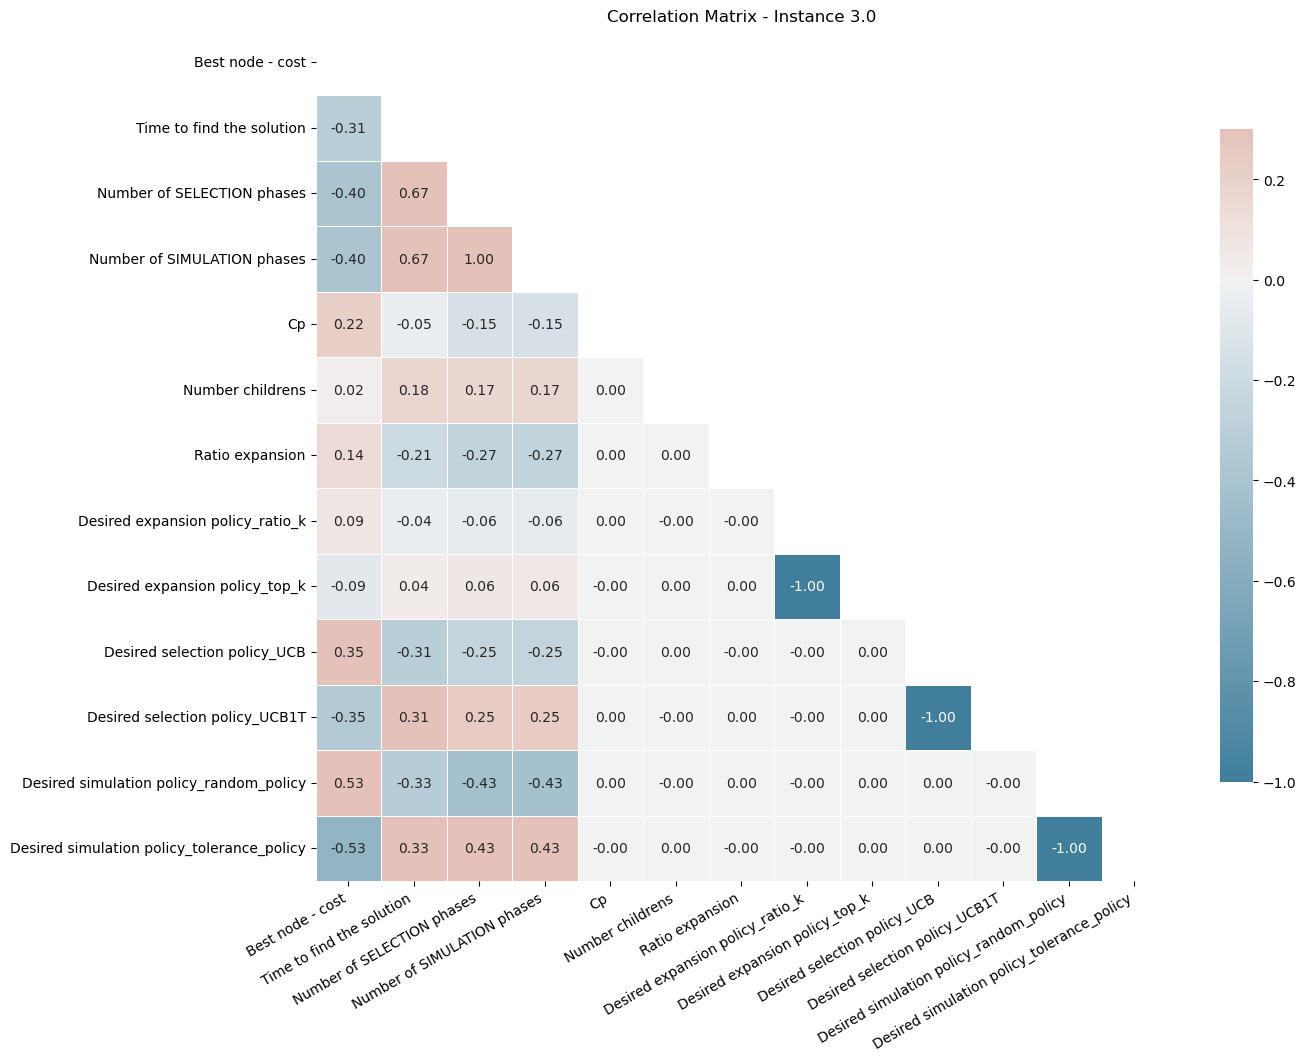

In [125]:
DV.correlation_matrix()

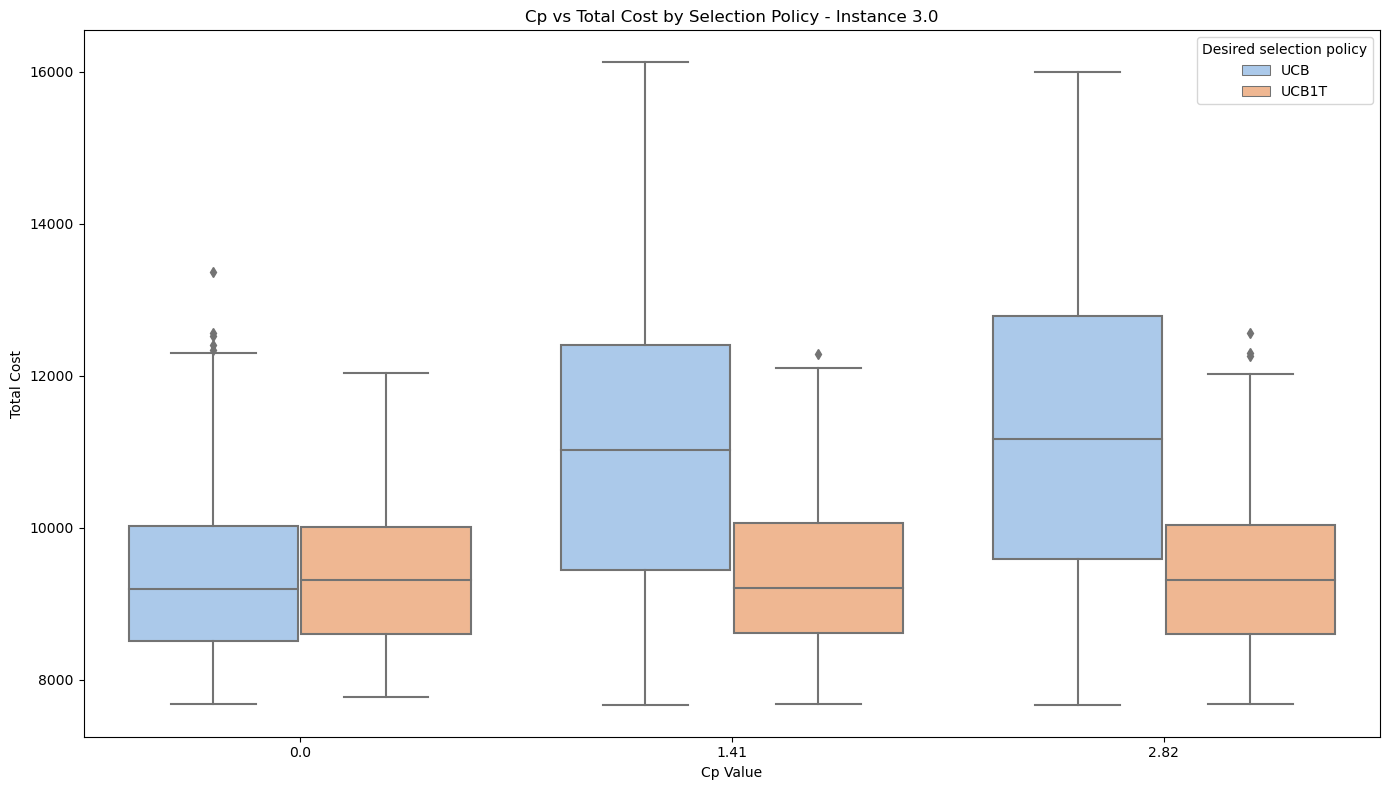

In [126]:
DV.cp_vs_cost()

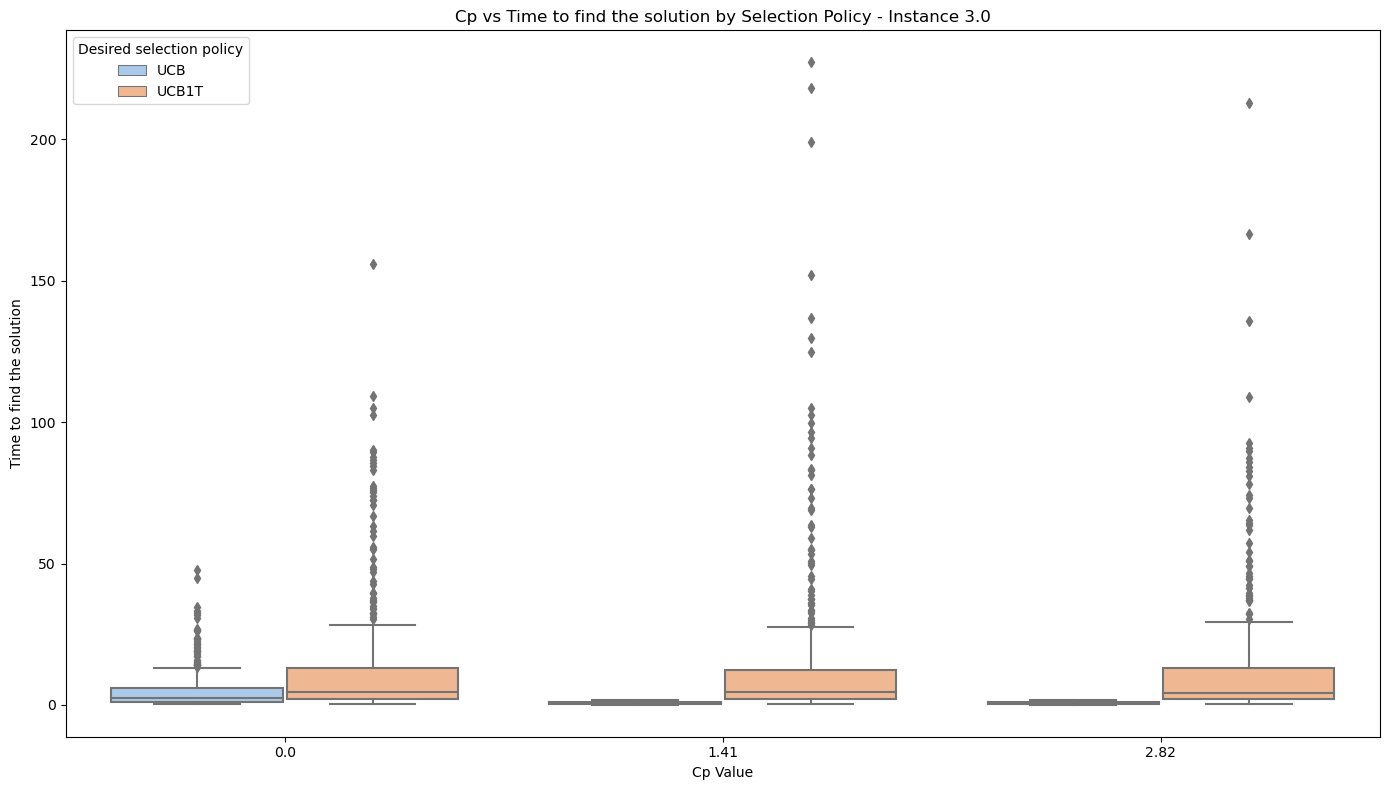

In [127]:
DV.cp_vs_time()

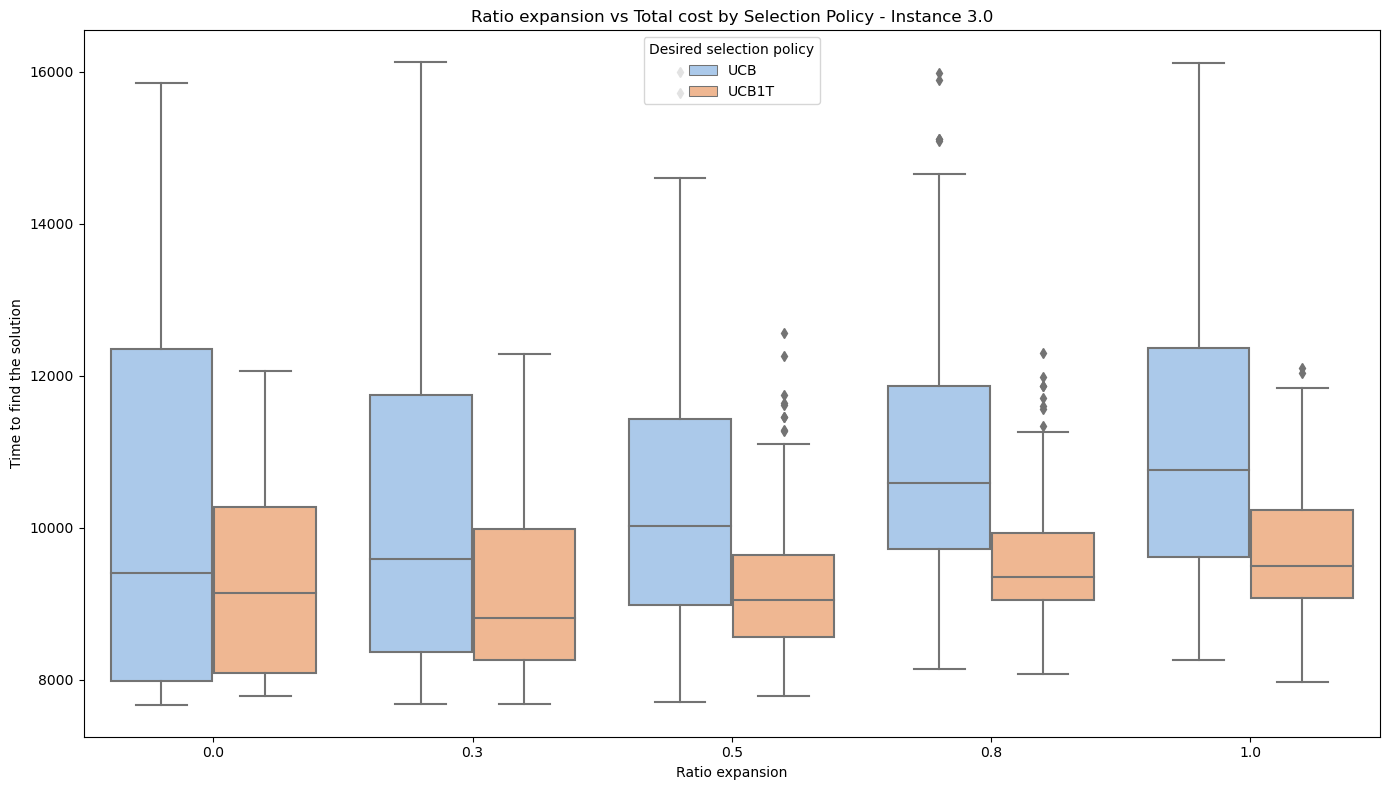

In [128]:
DV.cost_vs_ratio()

In [129]:
DV.best_result()

,Desired selection policy,Desired expansion policy,Desired simulation policy,Number childrens,Ratio expansion,Cp,Best node - cost,mean,std,Time to find the solution
152,UCB,top k,tolerance,10.0,0.0,2.82,7672.0,7672.00,0.00,0.2672
151,UCB,top k,tolerance,10.0,0.0,1.41,7672.0,7672.00,0.00,1.2835
211,UCB,top k,tolerance,15.0,0.0,1.41,7672.0,7672.00,0.00,1.4513
212,UCB,top k,tolerance,15.0,0.0,2.82,7672.0,7672.00,0.00,1.7256
110,UCB1T,ratio k,tolerance,15.0,0.3,2.82,7676.0,8353.89,485.93,44.6822
...,...,...,...,...,...,...,...,...,...,...
122,UCB,top k,random,10.0,0.0,2.82,11224.0,12626.33,931.79,0.7539
187,UCB,top k,random,15.0,0.5,1.41,11420.0,12839.44,1213.70,0.9941
74,UCB,ratio k,random,15.0,1.0,2.82,11698.0,12593.67,878.29,0.8024
2,UCB,ratio k,random,10.0,0.0,2.82,11786.0,13598.33,954.10,1.0239
